# End-to-end Multi-class Crime Text Classification using Pyspark

Apache Spark's ability to process streaming data efficiently makes it an ideal choice for developing our Crime Classification System. Leveraging Spark's Machine Learning Library (MLlib) and its Pipelines API, we will build a robust end-to-end solution for multi-class text classification.

## 1. Problem

Law enforcement agencies often face challenges in efficiently categorizing crimes based on descriptions, which can be time-consuming and prone to errors. To address this issue and improve resource allocation, we aim to develop an automated Crime Classification System. This system will accurately classify crime descriptions into predefined categories using machine learning techniques tailored to multi-class text classification.

## 2. Data

We will utilize a dataset sourced from Kaggle on San Francisco Crime, containing information such as crime descriptions, dates, day of the week, police district, and more. The dataset will serve as the foundation for training and testing our Crime Classification System.

https://www.kaggle.com/c/sf-crime/data

## 3. Features

The dataset used for developing the Crime Classification System contains the following features:

* Dates: Date and time of the crime incident.
* Category: Predefined category of the crime. This is our **target variable** and is only available in the training set.
* Descript: Description of the crime incident.
* DayOfWeek: Day of the week when the crime occurred.
* PdDistrict: Police district where the crime occurred.
* Resolution: How the crime incident was resolved.
* Address: Address or location of the crime incident.
* X: Longitude coordinate of the crime location.
* Y: Latitude coordinate of the crime location.

These features provide essential information about each crime incident, including its timing, location, category, and description. By analyzing these features, we can train machine learning models to accurately classify crime descriptions into predefined categories, aiding law enforcement agencies in resource allocation and investigation prioritization.





In [ ]:
# pip insall pyspark for our project
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=5234ff54a9cb5ad179090ccc7963208b25c25c0e4ae15819c8e10b19ab66669d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Import necessary libraries
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Initialize Spark Context and SQL Context
spark_context = SparkContext()
sql_context = SQLContext(spark_context)

# Load data from CSV
data = sql_context.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('train.csv')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Drop unnecessary columns
not_necessary = ['Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
data = data.select([column for column in data.columns if column not in not_necessary])

## Data Exploration (Exploratory Data Analysis or EDA)
The objective of this EDA is to gain insights into the San Francisco crime dataset, including the nature and frequency of different types of crimes. By analyzing the data, we aim to identify trends and patterns that can inform further analysis and modeling efforts.

* **Counting Occurrences:** We start by counting the occurrences of each crime category and description in the dataset. This helps us understand the frequency distribution of different types of crimes recorded in San Francisco.

* **Analysis of Categories:** We analyze the distribution of crime categories by counting the occurrences of each category. This step provides insights into which types of crimes are most prevalent in the dataset.

* **Analysis of Descriptions:** Similarly, we analyze the distribution of crime descriptions by counting their occurrences. This allows us to identify the most common descriptions associated with reported crimes.

* **Visualizations:** We use visualizations such as countplots to illustrate the distribution of crime categories and the top 20 crime descriptions. These visual representations make it easier to interpret and understand the patterns in the data.



In [ ]:
# Explore data by counting occurrences of categories and descriptions
data.groupBy("Category").count().orderBy(col("count").desc()).show()
data.groupBy("Descript").count().orderBy(col("count").desc()).show()

+--------------------+------+
|            Category| count|
+--------------------+------+
|       LARCENY/THEFT|174900|
|      OTHER OFFENSES|126182|
|        NON-CRIMINAL| 92304|
|             ASSAULT| 76876|
|       DRUG/NARCOTIC| 53971|
|       VEHICLE THEFT| 53781|
|           VANDALISM| 44725|
|            WARRANTS| 42214|
|            BURGLARY| 36755|
|      SUSPICIOUS OCC| 31414|
|      MISSING PERSON| 25989|
|             ROBBERY| 23000|
|               FRAUD| 16679|
|FORGERY/COUNTERFE...| 10609|
|     SECONDARY CODES|  9985|
|         WEAPON LAWS|  8555|
|        PROSTITUTION|  7484|
|            TRESPASS|  7326|
|     STOLEN PROPERTY|  4540|
|SEX OFFENSES FORC...|  4388|
+--------------------+------+
only showing top 20 rows

+--------------------+-----+
|            Descript|count|
+--------------------+-----+
|GRAND THEFT FROM ...|60022|
|       LOST PROPERTY|31729|
|             BATTERY|27441|
|   STOLEN AUTOMOBILE|26897|
|DRIVERS LICENSE, ...|26839|
|      WARRANT ARREST|

<ipython-input-6-1cd32441d11f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data.toPandas(), x='Category', order=category_counts['Category'], palette='viridis')


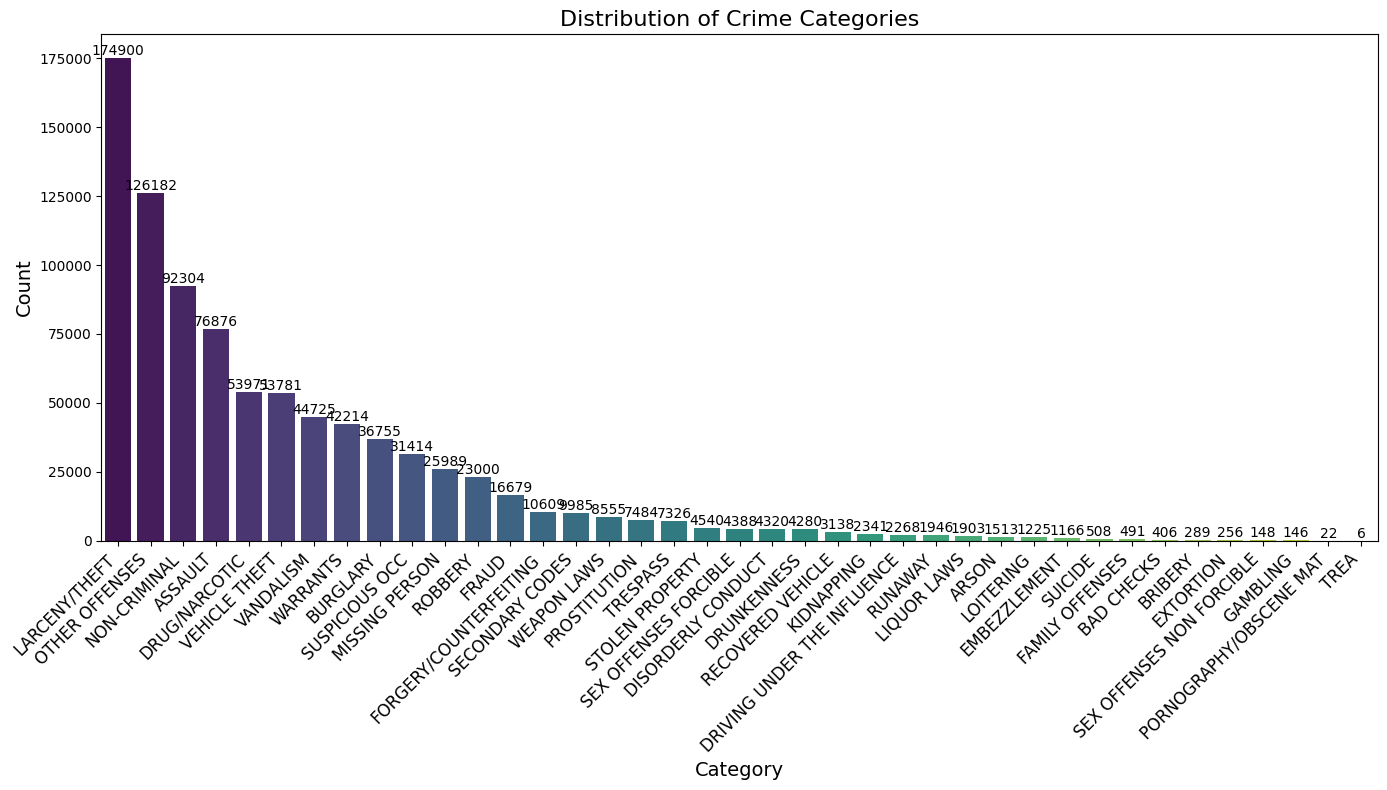

In [ ]:
# Get the count of each category and order them by count
category_counts = data.groupBy("Category").count().orderBy(col("count").desc()).toPandas()

# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create the countplot
sns.countplot(data=data.toPandas(), x='Category', order=category_counts['Category'], palette='viridis')

# Add title and labels
plt.title('Distribution of Crime Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add count labels on top of each bar
for index, value in enumerate(category_counts['count']):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

<ipython-input-7-fb948bdc15d1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data.toPandas(), y='Descript', order=top_descriptions, palette='viridis')


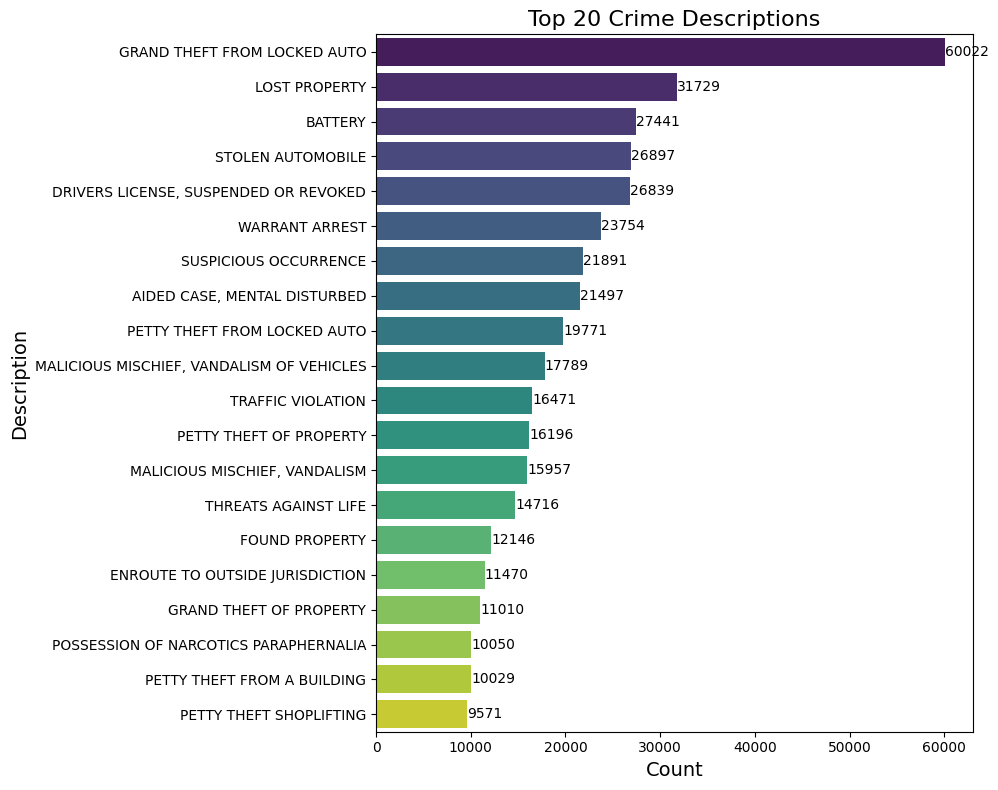

In [ ]:
# Get the top 20 crime descriptions and order them by count
top_descriptions = data.groupBy("Descript").count().orderBy(col("count").desc()).toPandas()['Descript'][:20]

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create the countplot
sns.countplot(data=data.toPandas(), y='Descript', order=top_descriptions, palette='viridis')

# Add title and labels
plt.title('Top 20 Crime Descriptions', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Description', fontsize=14)

# Add count labels on the right of each bar
for index, value in enumerate(data.groupBy("Descript").count().orderBy(col("count").desc()).toPandas()['count'][:20]):
    plt.text(value, index, str(value), ha='left', va='center', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

## Model Pipeline:
Our model pipeline consists of several steps:

* **regexTokenizer:** Tokenization using Regular Expression.
* **stopwordsRemover:** Removing stop words.
* **countVectors:** Generating count vectors for text data.
* **StringIndexer:** Encoding labels to label indices. In our case, the label column (Category) will be encoded to label indices.

In [ ]:
# Initialize RegexTokenizer for tokenization
regex = RegexTokenizer(inputCol="Descript", outputCol="words", pattern="\\W")

# Initialize StopWordsRemover for removing stop words
stopwords = ["http", "https", "amp", "rt", "t", "c", "the"]  # standard stop words
no_stopwords = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopwords)

# Initialize CountVectorizer for bag of words count
vectors_count = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

# Initialize StringIndexer for encoding labels
stringIdx = StringIndexer(inputCol="Category", outputCol="label")

In [ ]:
# Create a pipeline for data preprocessing and model training
pipeline = Pipeline(stages=[regex, no_stopwords, vectors_count, stringIdx])

# Fit the pipeline to the data
pipeline = pipeline.fit(data)
data1 = pipeline.transform(data)

In [ ]:
# Display the first 5 rows of the transformed dataset
data1.show(5)

+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      Category|            Descript|               words|            filtered|            features|label|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      WARRANTS|      WARRANT ARREST|   [warrant, arrest]|   [warrant, arrest]|(809,[17,32],[1.0...|  7.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(809,[11,17,35],[...|  1.0|
|OTHER OFFENSES|TRAFFIC VIOLATION...|[traffic, violati...|[traffic, violati...|(809,[11,17,35],[...|  1.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(809,[0,2,3,4,6],...|  0.0|
| LARCENY/THEFT|GRAND THEFT FROM ...|[grand, theft, fr...|[grand, theft, fr...|(809,[0,2,3,4,6],...|  0.0|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



## Model Training and Evaluation:

We employ various supervised machine learning algorithms in Spark, including:

* Logistic Regression using Count Vector Features.
* Logistic Regression using TF-IDF features.
* Random Forest
* Decision Tree Classifier

In addition, we also utilize techniques such as cross-validation to tune hyperparameters and improve model performance.

In [ ]:
# Split data into training and test sets
(train, test) = data1.randomSplit([0.7, 0.3], seed=100)

# Print counts of training and test datasets
print("Train Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Train Dataset Count: 614485
Test Dataset Count: 263564


## Logistic Regression using Count Vector Features

We train a logistic regression model using count vector features extracted from the crime descriptions. Count vectorization converts text data into numerical features representing the frequency of each word in the corpus. The logistic regression algorithm is applied to these features to classify the crimes into different categories.

In [ ]:
# Initialize Logistic Regression model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train the Logistic Regression model
lr_model = lr.fit(train)

# Make predictions on the test data
log_predictions = lr_model.transform(test)

# Show top 10 predictions with highest probability for label 0
log_predictions.filter(log_predictions['prediction'] == 0) \
    .select("Descript","Category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=10, truncate=30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.873295659207095,0.020134...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [ ]:
# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
log_accuracy = evaluator.evaluate(log_predictions)
print("Logistic Regression Accuracy: ", log_accuracy)

Logistic Regression Accuracy:  0.9720732319761755


## Logistic Regression using TF-IDF Features

Following the count vectorization, we also train another logistic regression model using TF-IDF (Term Frequency-Inverse Document Frequency) features. TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents. This approach aims to capture the significance of words in distinguishing between different crime categories.

In [ ]:
# Initialize HashingTF and IDF for TF-IDF feature extraction
hashing = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

# Redefine the pipeline with HashingTF and IDF
pipeline = Pipeline(stages=[regex, no_stopwords, hashing, idf, stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

# Split the dataset into training and test sets again
(train, test) = dataset.randomSplit([0.7, 0.3], seed=100)

# Initialize Logistic Regression model with TF-IDF features
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Train the Logistic Regression model with TF-IDF features
lr_model = lr.fit(train)

# Make predictions on the test data with TF-IDF features
lr_predictions = lr_model.transform(test)

# Show top 10 predictions with highest probability for label 0 using TF-IDF features
lr_predictions.filter(lr_predictions['prediction'] == 0) \
    .select("Descript", "Category", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=10, truncate=30)

+------------------------------+-------------+------------------------------+-----+----------+
|                      Descript|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8823125586072178,0.01884...|  0.0|       0.0|
|THEFT, BICYCLE, <$50, NO SE...|LARCENY/THEFT|[0.8

In [ ]:
# Evaluate the model with TF-IDF features using MulticlassClassificationEvaluator
accuracy_tf_idf = evaluator.evaluate(lr_predictions)
print("Logistic Regression Accuracy (TF-IDF):", accuracy_tf_idf)

Logistic Regression Accuracy (TF-IDF): 0.9717131220920647


* A Logistic Regression accuracy of **97.20%** suggests that the model is performing exceptionally well in predicting the crime categories based on the given features. In the context of this problem, where accurately classifying crime descriptions into predefined categories is crucial for law enforcement resource allocation, such high accuracy indicates that the model can effectively assist in prioritizing and addressing various types of crimes. This level of accuracy implies that the model is successfully capturing the patterns and relationships within the dataset, making it a valuable tool for supporting law enforcement agencies in their decision-making processes.

* Furthermore, the logistic regression model utilizing TF-IDF features exhibits a similarly high accuracy rate of **97.17%**. These results affirm that logistic regression, when coupled with appropriate feature representations like TF-IDF, excels in categorizing crime descriptions accurately. The robust performance of logistic regression underscores its suitability for this text classification problem, emphasizing the significance of **effective feature engineering** in enhancing model performance.

## Cross Validation

To ensure the robustness of our models and optimize their hyperparameters, we use cross-validation. Cross-validation involves splitting the dataset into multiple subsets, training the model on different combinations of these subsets, and evaluating its performance. By tuning hyperparameters through cross-validation, we aim to improve the generalization ability of our models and prevent overfitting to the training data.

We will only tune the **Count Vectors Logistic Regression.**

In [ ]:
# Configure parameters for grid search
Grid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5])
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2])
             .build())

# Initialize cross-validator
cross_valid = CrossValidator(estimator=lr, estimatorParamMaps=Grid, evaluator=evaluator, numFolds=5)

# Run cross-validation to tune hyperparameters
cv_model = cross_valid.fit(train)

# Make predictions using the best model selected by cross-validation
predictions = cv_model.transform(test)

In [ ]:
# Evaluate the tuned model
accuracy_cross_valid = evaluator.evaluate(predictions)
print("Cross-validated Logistic Regression Accuracy:", accuracy_cross_valid)

Cross-validated Logistic Regression Accuracy: 0.9913171037776416


Achieving a cross-validated Logistic Regression accuracy of **99.13%** shows how effective cross-validation is in making our model better. Through cross-validation, we iteratively fine-tuned the model's hyperparameters, optimizing its ability to generalize to new, unseen data. This process allowed us to systematically evaluate various parameter configurations and select the ones that yielded the best performance. As a result, the model demonstrates exceptional accuracy in predicting crime categories, showcasing the significant improvement achieved through cross-validation. By leveraging this technique, we were able to enhance the robustness and reliability of the model, ensuring its efficacy in real-world applications such as law enforcement resource allocation.

## Random Forest

Lastly, we employ the Random Forest algorithm, a popular ensemble learning technique that constructs multiple decision trees during training and outputs the mode of the classes as the prediction.

In [ ]:
# Initialize Random Forest classifier
random_for = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=4, maxBins=32)

# Train the Random Forest model
forest = random_for.fit(train)

# Make predictions using Random Forest classifier
forest_predictions = forest.transform(test)

# Show top 10 predictions with highest probability for label 0 using Random Forest
forest_predictions.filter(forest_predictions['prediction'] == 0) \
    .select("Descript", "Category", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=10, truncate=30)

+----------------------------+-------------+------------------------------+-----+----------+
|                    Descript|     Category|                   probability|label|prediction|
+----------------------------+-------------+------------------------------+-----+----------+
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.11945...|  0.0|       0.0|
|GRAND THEFT FROM LOCKED AUTO|LARCENY/THEFT|[0.3209013609963076,0.1194

In [ ]:
# Evaluate the Random Forest model
accuracy_rf = evaluator.evaluate(forest_predictions)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.37780935144768335


Random Forest is generally robust, but it's not ideal for high-dimensional sparse data. In such cases, where there are many features with low predictive power, Random Forest's performance may suffer. This is because it relies on decision trees, which can struggle with inefficient splitting decisions in such datasets. Linear models like Logistic Regression or Naive Bayes are often more suitable for handling high-dimensional sparse data efficiently. Therefore, while Random Forest has its strengths, it's important to consider the dataset's characteristics and explore alternative algorithms for better performance.

## Decision Tree classifier

Incorporating a Decision Tree classifier into our crime classification task allows us to create a hierarchical structure that learns from the features provided in the dataset to predict the corresponding crime categories. By setting parameters like the maximum depth of the tree, we control the complexity of the model and its ability to capture intricate patterns in the data. The Decision Tree algorithm splits the dataset into subsets based on the most significant features, creating a tree-like structure where each internal node represents a feature, each branch corresponds to a decision based on that feature, and each leaf node represents a predicted category. This method enables interpretable predictions, as we can trace the path from the root to the leaf node to understand how the model arrives at its decision.

In [ ]:
# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=4)

# Train the Decision Tree model
dtModel = dt.fit(train)

# Make predictions using Decision Tree classifier
dt_predictions = dtModel.transform(test)

# Show top 10 predictions with highest probability for label 0 using Decision Tree
dt_predictions.filter(dt_predictions['prediction'] == 0) \
    .select("Descript", "Category", "probability", "label", "prediction") \
    .orderBy("probability", ascending=False) \
    .show(n=10, truncate=30)

+-------------------------+--------+------------------------------+-----+----------+
|                 Descript|Category|                   probability|label|prediction|
+-------------------------+--------+------------------------------+-----+----------+
|SHORT CHANGE, GRAND THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, GRAND THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0...| 12.0|       0.0|
|SHORT CHANGE, PETTY THEFT|   FRAUD|[0.9961332637212034,0.0,0.0..

In [ ]:
# Evaluate the Decision Tree model
treeaccuracy = evaluator.evaluate(dt_predictions)
print("Decision Tree Model Accuracy:", treeaccuracy)

Decision Tree Model Accuracy: 0.4153018894022133


The relatively low accuracy of the Decision Tree Model suggests that the decision tree model is not performing well in accurately predicting crime categories based on the given features.

The reason for this low accuracy could be the inherent limitations of decision trees, especially when dealing with high-dimensional and sparse data, as is often the case in text classification problems like crime categorization. Decision trees tend to create overly complex models, which can lead to overfitting, where the model learns to memorize the training data rather than generalize to new, unseen data. Additionally, decision trees may struggle to capture the intricate relationships and patterns present in textual data, resulting in suboptimal performance.

## Evaluation Results:

Based on the evaluation results, it's clearly evident that logistic regression, particularly when optimized through cross-validation, is the most suitable model for the task of crime categorization based on textual data, outperforming both the Decision Tree and Random Forest models. The high accuracy of the logistic regression model underscores its efficacy in assisting law enforcement agencies in allocating resources and prioritizing investigations.

Overall, the project also highlights the importance of employing appropriate machine learning algorithms and techniques for text classification tasks, emphasizing the superior performance of logistic regression with cross-validation in this context.

## Conclusion

The Crime Classification System developed using PySpark offers a valuable tool for law enforcement agencies to accurately categorize crime descriptions and allocate resources effectively. By automating the classification process, this system contributes to enhancing public safety and streamlining investigation prioritization.